# Natural Language Processing

Internal Project 

**Automatic Question Answering from FAQ using word embeddings**

---



In this project, we examine the task of automatically retrieving a suitable response to user questions from FAQs. Often websites have comprehensive FAQs, but manually searching and finding the answer to a specific question from these FAQs is not trivial. The purpose of this exercise is to answer user queries by automatically retrieving the **closest question** and answer from predefined FAQs when appropriate.

We will use a sample dataset of FAQs extracted from the site https://www.fda.gov/emergency-preparedness-and-response/coronavirus-disease-2019-covid-19/covid-19-frequently-asked-questions for this task. This dataset can be replaced with a more elaborate dataset as appropriate.

Our basic strategy is as follows: For a given query, find the FAQ question that is closest in meaning to the user query and display it to the user. For this, we need to have an efficient way of computing Semantic Similarity between two sentences.

To compute Semantic Similarity between sentences, we will convert each sentence into a **vector**. We can then use **cosine similarity between vectors** to come up with a distance measure between sentences that indicates how similar they are in meaning.


Reference: https://youtu.be/ZxR38An5TQE

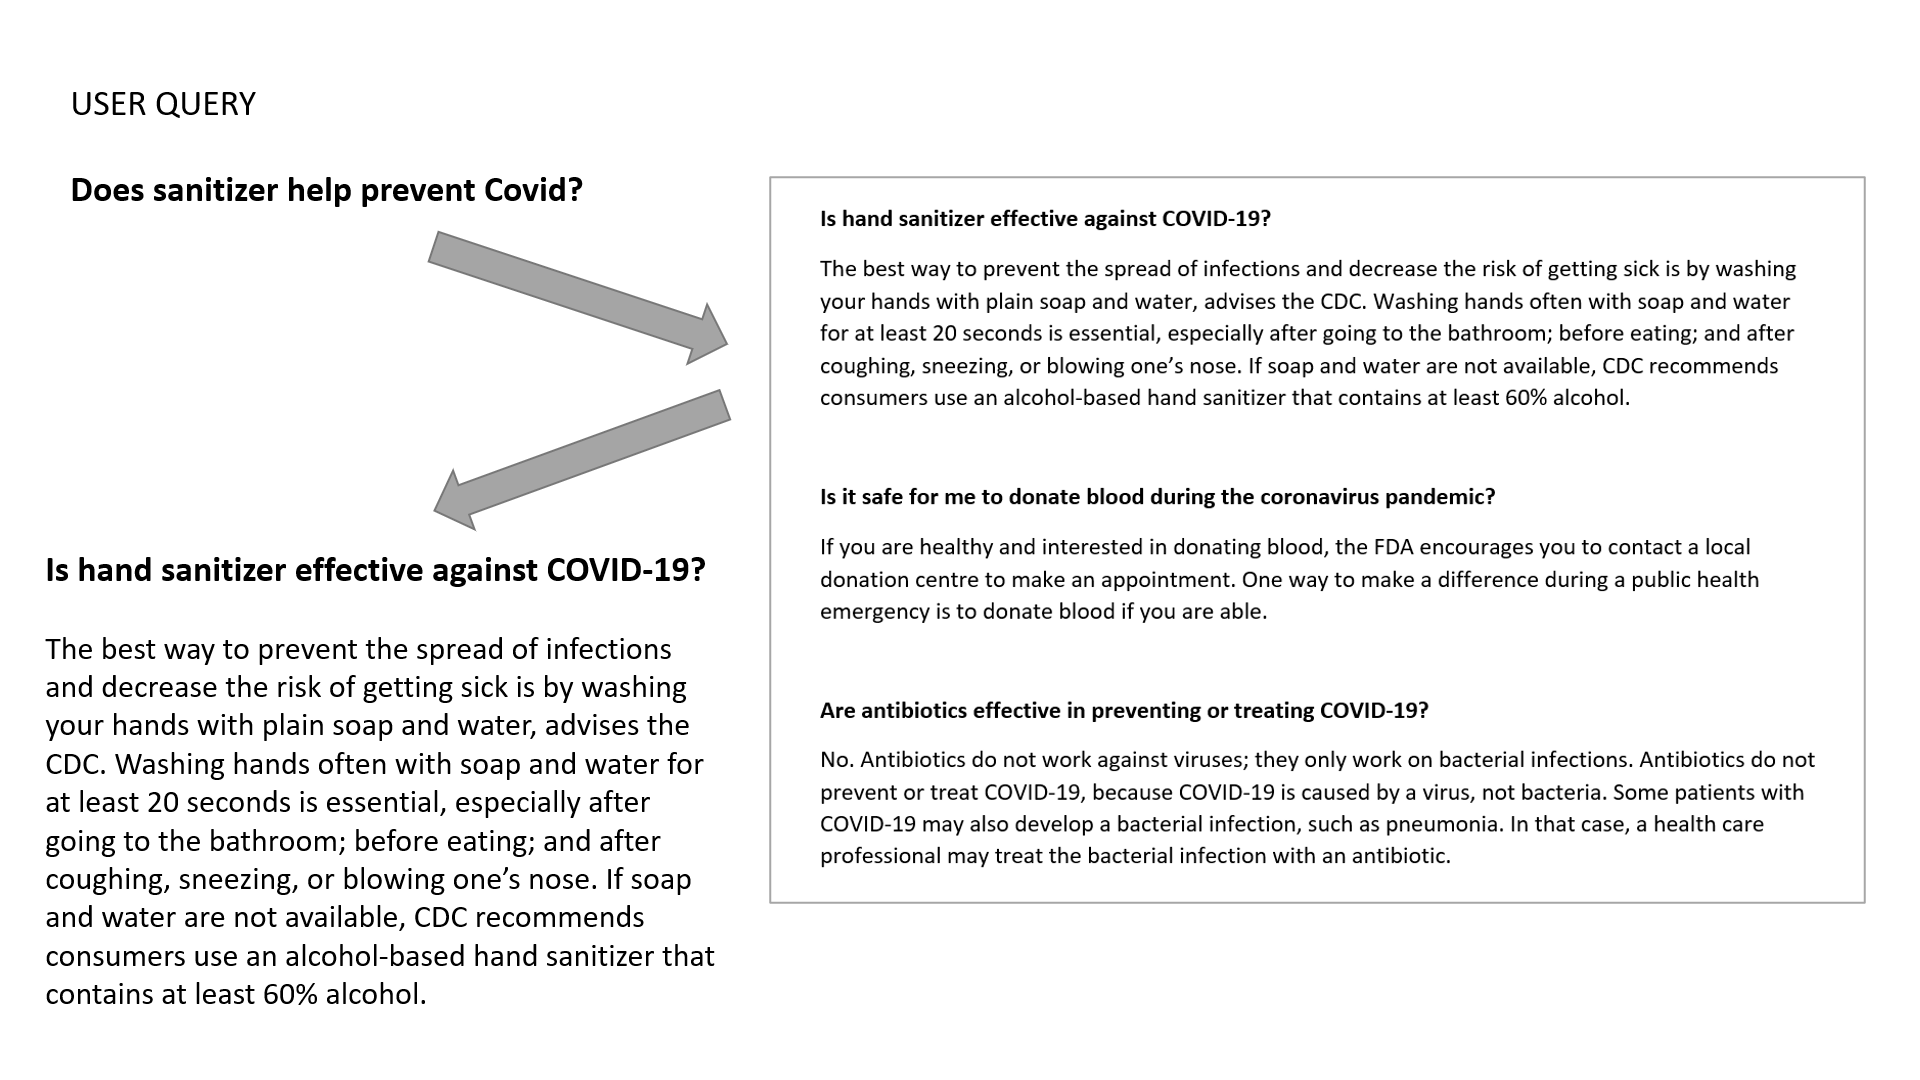

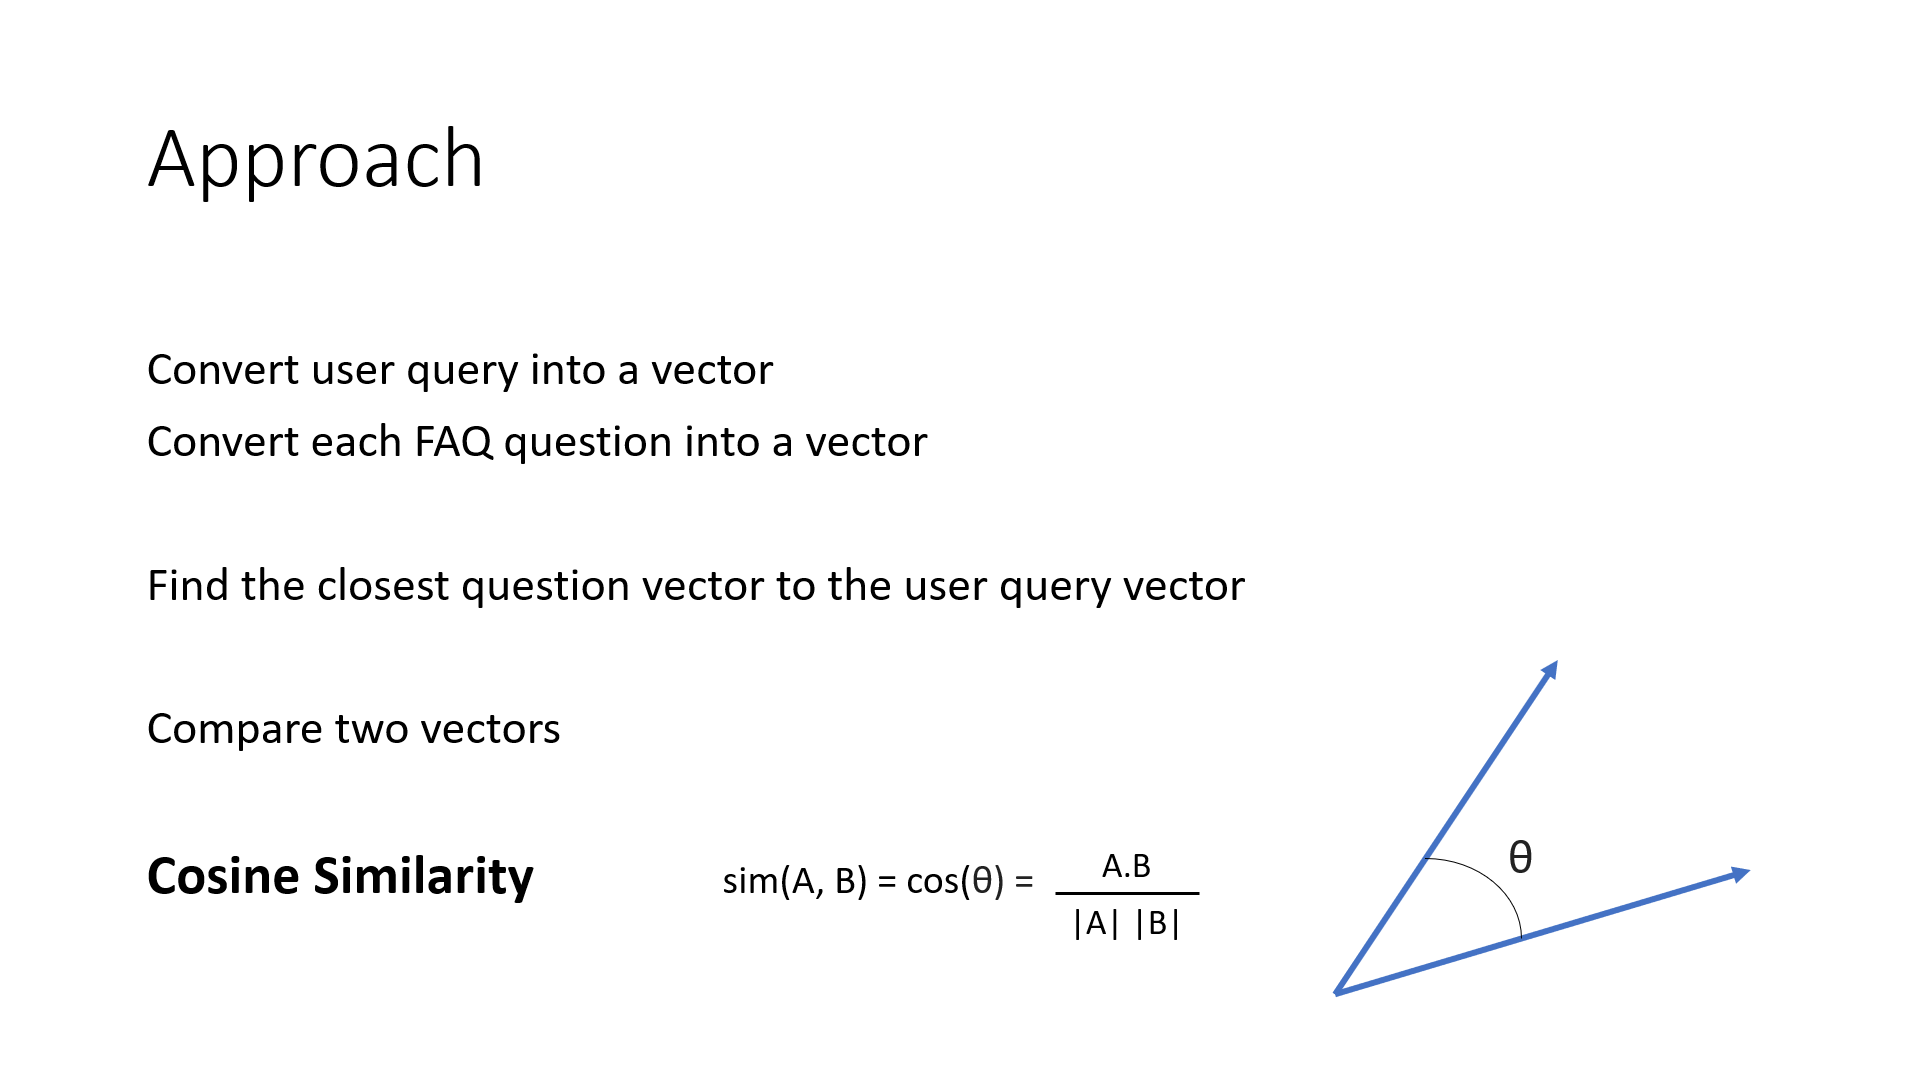

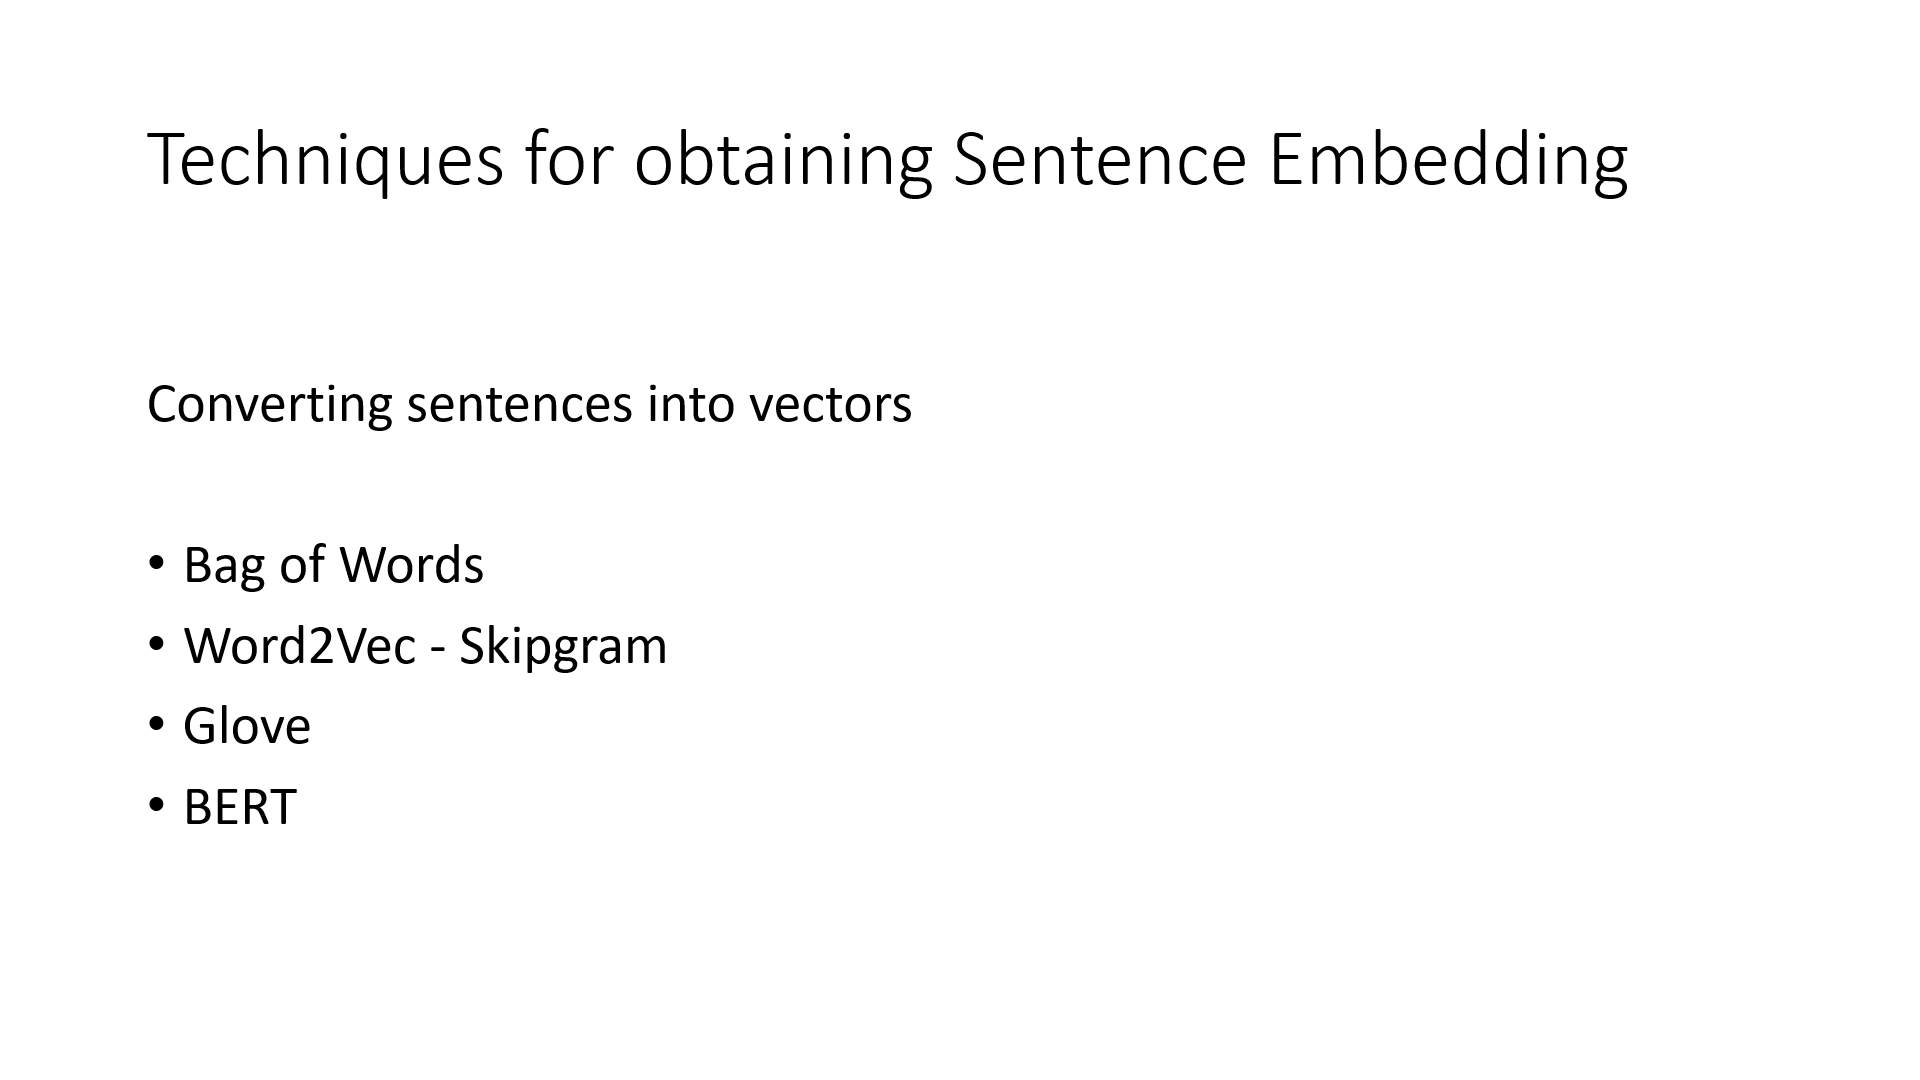

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

**Load Dataset**

In [ ]:
import pandas as pd;

# Load dataset and examine dataset, rename columns to questions and answers

df = pd.read_csv("Covid-19 FAQs.csv");
df.columns = ["questions","answers"];

df

,questions,answers
0,How can I prevent COVID-19?,The best way to prevent illness is to avoid be...
1,Does spraying people with disinfectant lower t...,Currently there are no data showing that spray...
2,Is hand sanitizer effective against COVID-19?,The best way to prevent the spread of infectio...
3,Where can I buy hand sanitizer? Can I make my ...,Many retail stores and pharmacies sell hand sa...
4,Are there any vaccines or other medical produc...,"Yes. On December 11, 2020 the FDA issued the f..."
5,Is it safe for me to donate blood during the c...,If you are healthy and interested in donating ...
6,Are antibiotics effective in preventing or tre...,No. Antibiotics do not work against viruses; t...
7,Will there be drug shortages due to COVID-19?,The FDA has been closely monitoring the supply...
8,Is there a test for COVID-19?,"Yes, the FDA has issued Emergency Use Authoriz..."
9,Is it safe to adopt pets from a shelter or res...,"There is no reason to think that any animals, ..."


**Preprocessing**

Most NLP tasks involve preprocessing. For this task we are performing the following preprocessing :

Removing all characters that are **not alpha numeric**.
Removing **stopwords** - commonly used words such as 'a', 'to', 'in' and so on.. that do not contribute to the semantic similarity between two sentences.
We apply this to both the FAQ questions and the user query sentence.

Note that we have an option to not perform stopword removal. This is because some of the later models such as BERT work well without stopword removal - and we will try that out.

In [ ]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

def clean_sentence(sentence, stopwords = False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
    
    if stopwords:
         sentence = remove_stopwords(sentence)

    return sentence
                    
def get_cleaned_sentences(df, stopwords = False):    
    sents = df[["questions"]]
    cleaned_sentences=[]

    for index, row in df.iterrows():
        cleaned = clean_sentence(row["questions"], stopwords)
        cleaned_sentences.append(cleaned)
    return cleaned_sentences

In [ ]:
cleaned_sentences = get_cleaned_sentences(df, stopwords = True)
cleaned_sentences

['prevent covid19',
 'spraying people disinfectant lower spread covid19',
 'hand sanitizer effective covid19',
 'buy hand sanitizer hand sanitizer',
 'vaccines medical products available prevent covid19',
 'safe donate blood coronavirus pandemic',
 'antibiotics effective preventing treating covid19',
 'drug shortages covid19',
 'test covid19',
 'safe adopt pets shelter rescue']

In [ ]:
cleaned_sentences_with_stopwords = get_cleaned_sentences(df, stopwords = False)
cleaned_sentences_with_stopwords

['how can i prevent covid19',
 'does spraying people with disinfectant lower the spread of covid19',
 'is hand sanitizer effective against covid19',
 'where can i buy hand sanitizer can i make my own hand sanitizer',
 'are there any vaccines or other medical products available to prevent covid19',
 'is it safe for me to donate blood during the coronavirus pandemic',
 'are antibiotics effective in preventing or treating covid19',
 'will there be drug shortages due to covid19',
 'is there a test for covid19',
 'is it safe to adopt pets from a shelter or rescue']

**Bag of words Model**

The first model we will use for semantic similarity is leveraging Bag of Words (BOW). With BOW, each sentence is encoded into a vector whose **length is the number of words in the vocabulary**. Each element of the vector indicates how many times the particular word occurs in the sentence. An example is shown below by printing the dictionary and the FAQ questions in the BOW **sparse format**.

Note that a vector representation of a sentence is often also called an "**Embedding**" since it is a way of embedding a sentence in M-dimensional space if the vector is of length M.

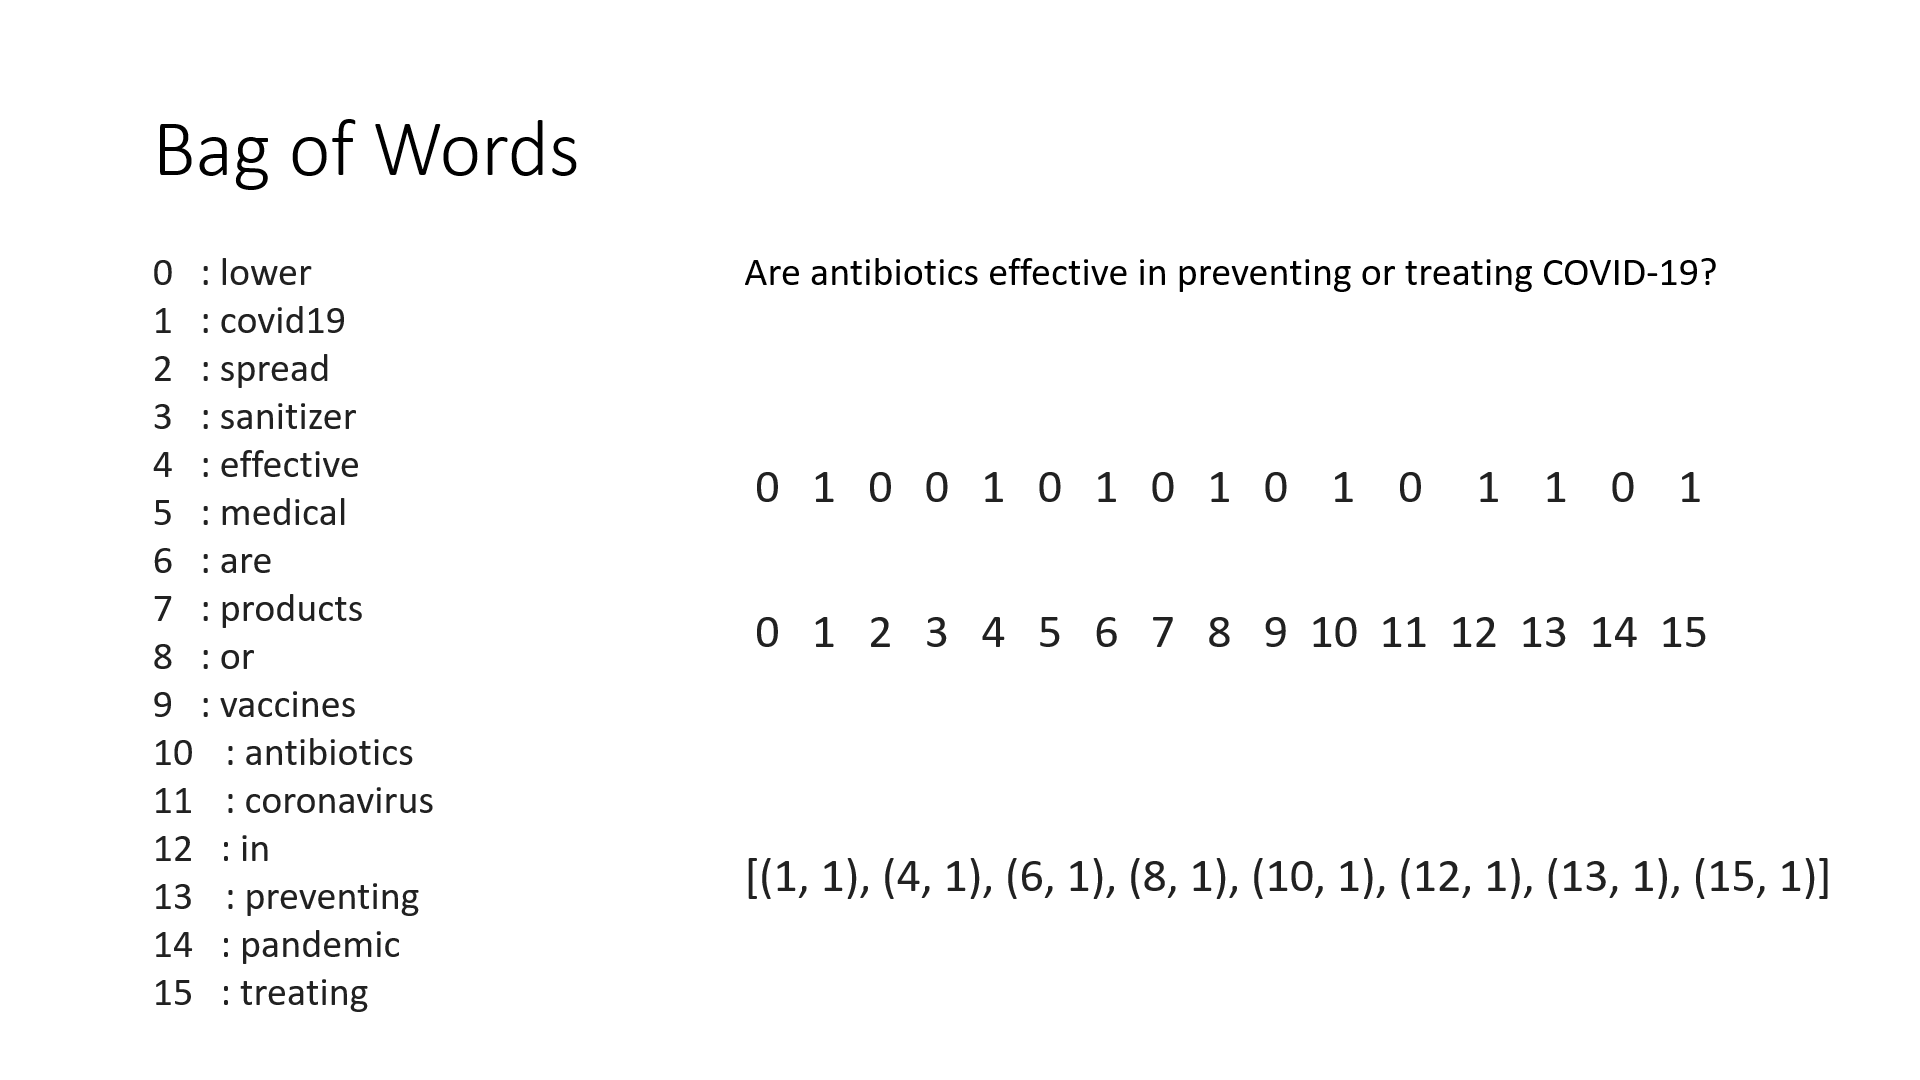

In [ ]:
import numpy
sentences = cleaned_sentences_with_stopwords
sentence_words = [[ word for word in document.split() ]
         for document in sentences]
sentence_words

[['how', 'can', 'i', 'prevent', 'covid19'],
 ['does',
  'spraying',
  'people',
  'with',
  'disinfectant',
  'lower',
  'the',
  'spread',
  'of',
  'covid19'],
 ['is', 'hand', 'sanitizer', 'effective', 'against', 'covid19'],
 ['where',
  'can',
  'i',
  'buy',
  'hand',
  'sanitizer',
  'can',
  'i',
  'make',
  'my',
  'own',
  'hand',
  'sanitizer'],
 ['are',
  'there',
  'any',
  'vaccines',
  'or',
  'other',
  'medical',
  'products',
  'available',
  'to',
  'prevent',
  'covid19'],
 ['is',
  'it',
  'safe',
  'for',
  'me',
  'to',
  'donate',
  'blood',
  'during',
  'the',
  'coronavirus',
  'pandemic'],
 ['are',
  'antibiotics',
  'effective',
  'in',
  'preventing',
  'or',
  'treating',
  'covid19'],
 ['will', 'there', 'be', 'drug', 'shortages', 'due', 'to', 'covid19'],
 ['is', 'there', 'a', 'test', 'for', 'covid19'],
 ['is',
  'it',
  'safe',
  'to',
  'adopt',
  'pets',
  'from',
  'a',
  'shelter',
  'or',
  'rescue']]

In [ ]:
from gensim import corpora

dictionary = corpora.Dictionary(sentence_words)
for key, value in dictionary.items():
    print(key, ' : ', value)

import pprint
bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]
for sent, embedding in zip(sentences, bow_corpus):
    print("\n")
    print(sent)
    print(embedding)

0  :  can
1  :  covid19
2  :  how
3  :  i
4  :  prevent
5  :  disinfectant
6  :  does
7  :  lower
8  :  of
9  :  people
10  :  spraying
11  :  spread
12  :  the
13  :  with
14  :  against
15  :  effective
16  :  hand
17  :  is
18  :  sanitizer
19  :  buy
20  :  make
21  :  my
22  :  own
23  :  where
24  :  any
25  :  are
26  :  available
27  :  medical
28  :  or
29  :  other
30  :  products
31  :  there
32  :  to
33  :  vaccines
34  :  blood
35  :  coronavirus
36  :  donate
37  :  during
38  :  for
39  :  it
40  :  me
41  :  pandemic
42  :  safe
43  :  antibiotics
44  :  in
45  :  preventing
46  :  treating
47  :  be
48  :  drug
49  :  due
50  :  shortages
51  :  will
52  :  a
53  :  test
54  :  adopt
55  :  from
56  :  pets
57  :  rescue
58  :  shelter


how can i prevent covid19
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


does spraying people with disinfectant lower the spread of covid19
[(1, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


is hand san

In [ ]:
question_orig = input("Enter question: ")
question = clean_sentence(question_orig, stopwords = False);
question_embedding = dictionary.doc2bow(question.split())

print("\n\n", question, "\n", question_embedding)

Enter question: how to check whether you are covid positive?


 how to check whether you are covid positive 
 [(2, 1), (25, 1), (32, 1)]


Once we find a vector representation for each sentence using BOW, we can compute the distance between two vectors by taking the cosine similarity. Note other similarity measure can be used as well, but we will stick to cosine similarity throughout for simplicity.

The closest matching answer can be retrieved by finding the cosine similarity of the query vector with each of the FAQ question vectors.

We see that in the example below, BOW representation did not do very well and retrieved the wrong answer since it is looking for exact word match. For instance the word "check" in the query is similar to "test" in "Is there a test for COVID-19? ?". However BOW cannot figure this out.

In [ ]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;

def retrieveAndPrintFAQAnswer(question_embedding, sentence_embeddings, FAQdf, sentences):
    max_sim = -1
    index_sim = -1
    for index, faq_embedding in enumerate(sentence_embeddings):
        sim = cosine_similarity(faq_embedding, question_embedding)[0][0]
        print(index, sim, sentences[index])
        if sim > max_sim:
            max_sim = sim
            index_sim = index
    
    print("\n")
    print("Question: ", question)
    print("\n");
    print("Retrieved: ", FAQdf.iloc[index_sim, 0], "\n")
    print(FAQdf.iloc[index_sim, 1])
    
retrieveAndPrintFAQAnswer(question_embedding, bow_corpus, df, sentences);

0 0.4472135954999579 how can i prevent covid19
1 0.9486832980505137 does spraying people with disinfectant lower the spread of covid19
2 0.9486832980505137 is hand sanitizer effective against covid19
3 0.4472135954999579 where can i buy hand sanitizer can i make my own hand sanitizer
4 0.9486832980505137 are there any vaccines or other medical products available to prevent covid19
5 0.9284766908852593 is it safe for me to donate blood during the coronavirus pandemic
6 0.9486832980505137 are antibiotics effective in preventing or treating covid19
7 0.9486832980505137 will there be drug shortages due to covid19
8 0.9486832980505137 is there a test for covid19
9 0.9191450300180577 is it safe to adopt pets from a shelter or rescue


Question:  how to check whether you are covid positive


Retrieved:  Does spraying people with disinfectant lower the spread of COVID-19? 

Currently there are no data showing that spraying people with aerosolized disinfectants, or having people walk through tu

**Word2Vec Embeddings**

Word2Vec embeddings are popularly trained using the **skipgram model**. These embeddings are trained to take a word as input and **reconstruct its context**. As a result, they are able to take into account **semantic similarity** of words based on context information. The resulting embeddings are such that words with similar meaning tend to be closer in terms of cosine similarity.

**Skipgram model**

The most popular word2vec model is the skipgram model. Particularly, the most commonly used pre-trained model is based on the Google News dataset that has 3 billion running words and creates upto 300 dimensional embedding for 3 Million words

You can find more information on the following page : https://code.google.com/archive/p/word2vec/



The relationship between words is derived by cosine distance between words. Such word vectors are good at answering analogy questions.

Semantically similar words are close together.

We can also use arithmetic on these embeddings to derive meaning.


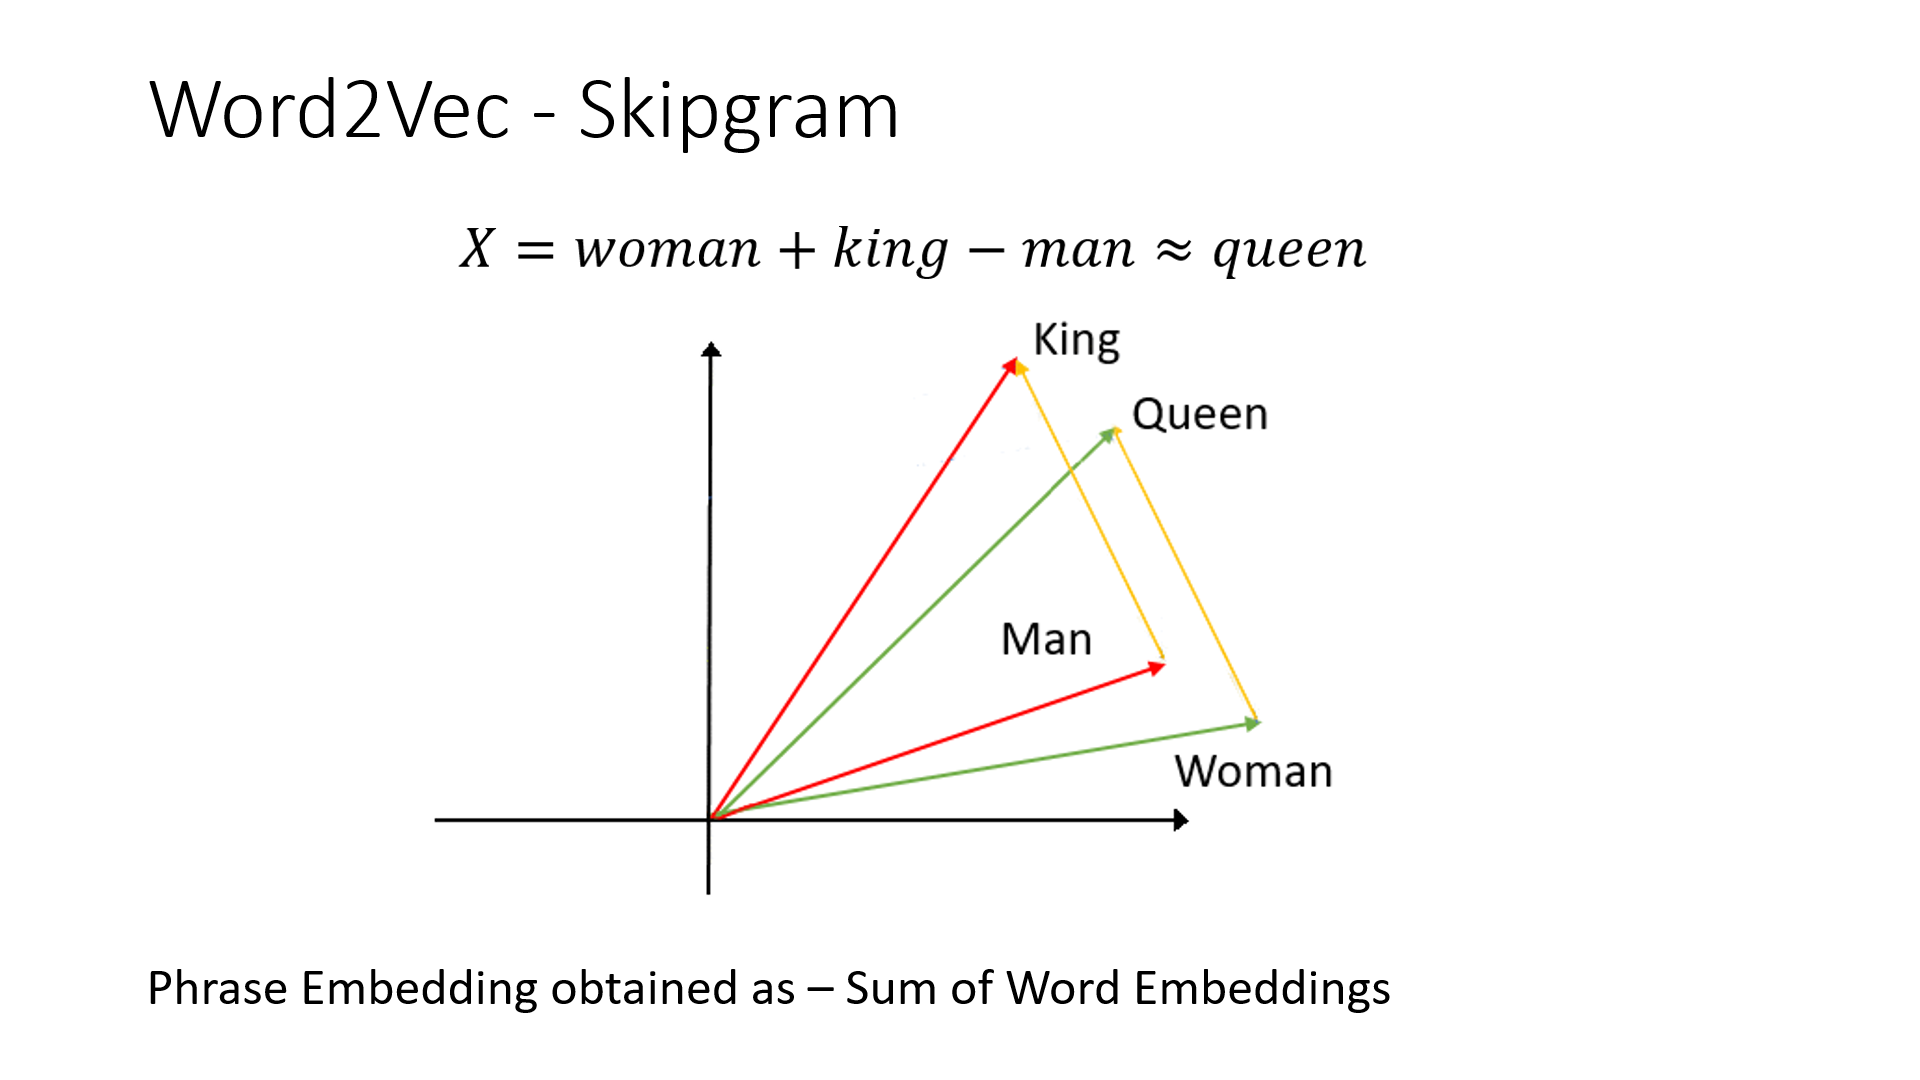

Word2Vec is a feed forward neural network based model to find word embeddings. There are two models that are commonly used to train these embeddings: The skip-gram and the CBOW model. 

The Skip-gram model takes the input as each word in the corpus, sends them to a hidden layer (embedding layer) and from there it predicts the context words. Once trained, the embedding for a particular word is obtained by feeding the word as input and taking the hidden layer value as the final embedding vector. 

The CBOW (Continuous Bag of Words) model takes the input the context words for the given word, sends them to a hidden layer (embedding layer) and from there it predicts the original word. Once again, after training, the embedding for a particular word is obtained by feeding the word as input and taking the hidden layer value as the final embedding vector. 

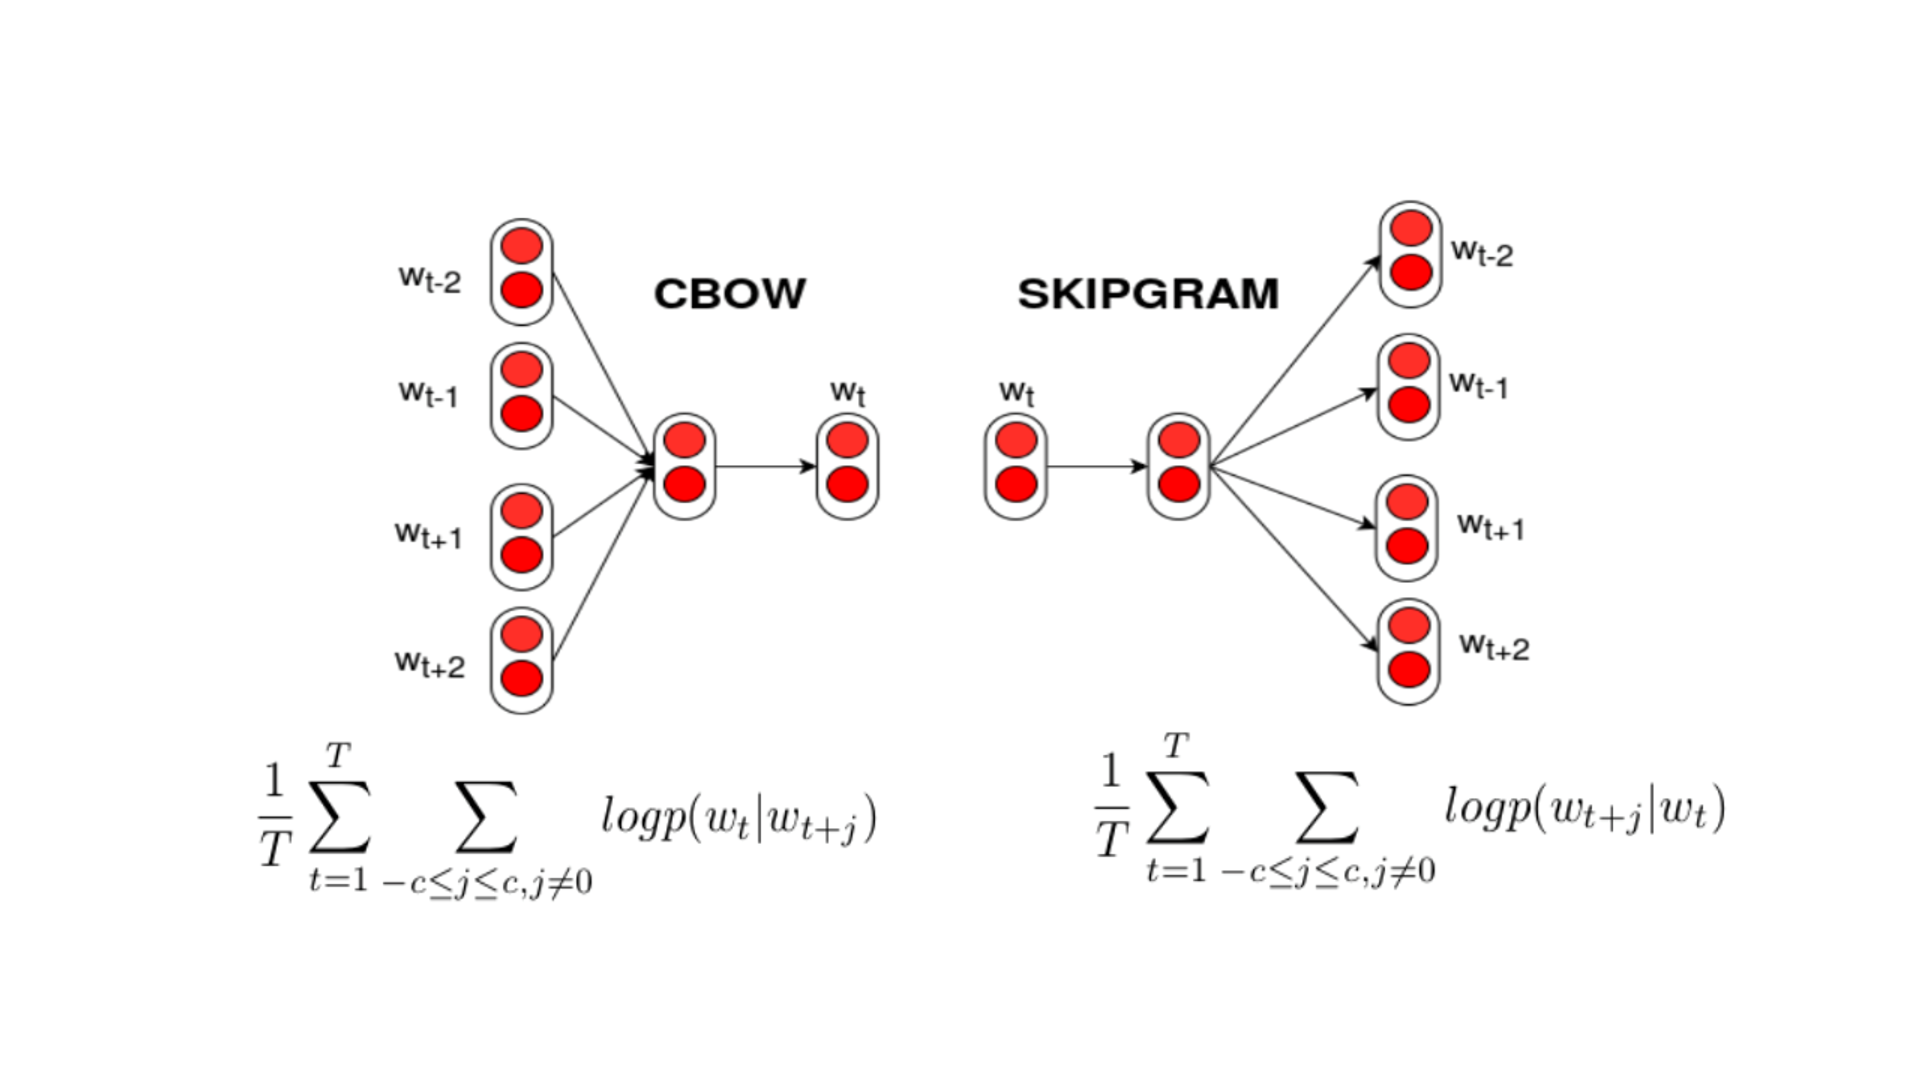

**Glove Embeddings**

Glove is an alternate approach to build word embeddings using matrix factorization techinques on the word-word co-occurance matrix.

https://nlp.stanford.edu/projects/glove/

Glove is based on matrix factorization techniques on the word-context matrix. It first constructs a large matrix of (words x context) co-occurrence information, i.e. for each “word” (the rows), you count how frequently we see this word in some “context” (the columns) in a large corpus.  The number of “contexts” is of course large, since it is essentially combinatorial in size.

So then we factorize this matrix to yield a lower-dimensional (word x features) matrix, where each row now yields a vector representation for the corresponding word. 


While both the techniques are popular, glove performs better on some datasets while word2vec skipgram model performs better on some. Here, we experiment with both the word2vec and the glove models.

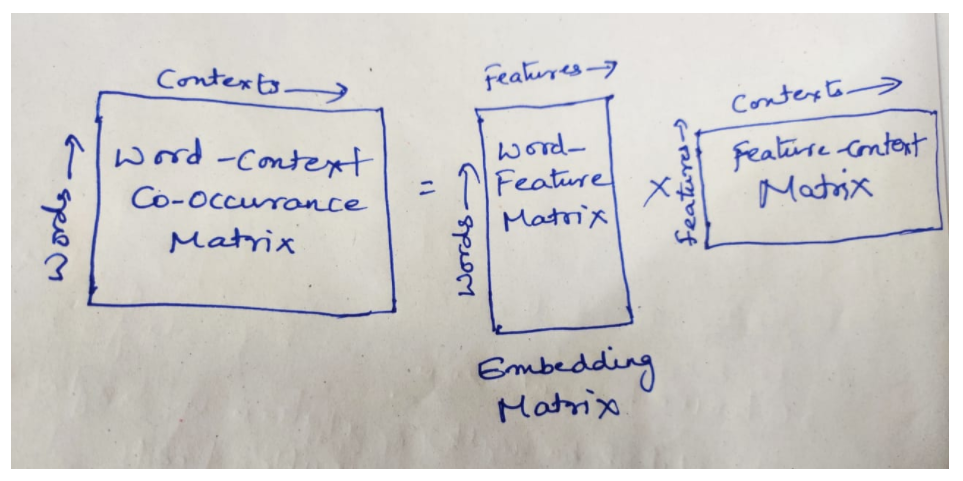

In [ ]:
from gensim.models import Word2Vec 
import gensim.downloader as api

glove_model = None
try:
    glove_model = gensim.models.KeyedVectors.load("./glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")
    
w2v_model = None
try:
    w2v_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    w2v_model = api.load('word2vec-google-news-300')
    w2v_model.save("./w2vecmodel.mod")
    print("Saved glove model")

w2vec_embedding_size = len(w2v_model['computer']);
glove_embedding_size = len(glove_model['computer']);
print(w2vec_embedding_size, glove_embedding_size)

Loaded glove model
Loaded w2v model
300 25


**Finding Phrase Embeddings from Word Embeddings**

To find phrase embeddings, there are several specialized techniques. The most simple technique to convert word embeddings to phrase embeddings, that is applicable with word2vec and glove embeddings, is to **sum up the individual word embeddings in the phrase to get a phrase vector**.

In [ ]:
def getWordVec(word, model):
        samp = model['computer'];
        vec = [0] * len(samp);
        try:
                vec = model[word];
        except:
                vec = [0]*len(samp);
        return (vec)

def getPhraseEmbedding(phrase, embeddingmodel):   
        samp = getWordVec('computer', embeddingmodel);
        vec = numpy.array([0] * len(samp));
        den = 0
        for word in phrase.split():
            den = den+1;
            vec = vec + numpy.array(getWordVec(word, embeddingmodel));
        return vec.reshape(1, -1)

In [ ]:
# With w2Vec

sent_embeddings = []
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent, w2v_model));
#print(sent_embeddings)
question_embedding=getPhraseEmbedding(question, w2v_model);

retrieveAndPrintFAQAnswer(question_embedding, sent_embeddings, df, cleaned_sentences);

0 0.170283011970491 prevent covid19
1 0.2902108328588452 spraying people disinfectant lower spread covid19
2 0.23392419778006499 hand sanitizer effective covid19
3 0.24926180768044806 buy hand sanitizer hand sanitizer
4 0.27486023547687544 vaccines medical products available prevent covid19
5 0.2997287943343968 safe donate blood coronavirus pandemic
6 0.22519236486159624 antibiotics effective preventing treating covid19
7 0.17901275345616452 drug shortages covid19
8 0.32927831683526043 test covid19
9 0.26735666372346484 safe adopt pets shelter rescue


Question:  how to check whether you are covid positive


Retrieved:  Is there a test for COVID-19? 

Yes, the FDA has issued Emergency Use Authorizations (EUAs) for different types of COVID-19 tests. Some tests are used to diagnose the virus that causes COVID-19 infection whereas other tests are used to detect a recent or prior COVID-19 infection. There are 2 different types of COVID-19 diagnostic tests -- molecular tests and antigen tes

In [ ]:
# With Glove

sent_embeddings = []
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent, glove_model));

question_embedding = getPhraseEmbedding(question, glove_model);

retrieveAndPrintFAQAnswer(question_embedding, sent_embeddings, df, cleaned_sentences);

0 0.6219620175435453 prevent covid19
1 0.7958598087039649 spraying people disinfectant lower spread covid19
2 0.7165781548015357 hand sanitizer effective covid19
3 0.7191355174861698 buy hand sanitizer hand sanitizer
4 0.7445585263521037 vaccines medical products available prevent covid19
5 0.7044723267257543 safe donate blood coronavirus pandemic
6 0.631361067067652 antibiotics effective preventing treating covid19
7 0.48110050411464145 drug shortages covid19
8 0.7249145538508267 test covid19
9 0.7296078522906774 safe adopt pets shelter rescue


Question:  how to check whether you are covid positive


Retrieved:  Does spraying people with disinfectant lower the spread of COVID-19? 

Currently there are no data showing that spraying people with aerosolized disinfectants, or having people walk through tunnels or rooms where disinfectant is in the air, can treat, prevent, or lower the spread of COVID-19.

Surface disinfectants should not be used on people or animals. Disinfectant product

**BERT EMBEDDINGS**

Bidirectional Encoder Representations from Transformers

https://www.blog.google/products/search/search-language-understanding-bert/

Instead of looking at words in isolation, BERT, a **transformer** based model attempts to use the context of words to get embeddings. BERT broke several records in NLP tasks in 2018, a huge leap in NLP. BERT uses several concepts in deep learning to come up with a model that looks at context in a bi-directional fashion, leveraging information from the entire sentence as a whole through self-attention. 

Take a look at https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/ for more information on BERT.


Google included examples demonstrating the effects of BERT in its announcement. One of the examples compared search results before and after the update for the query: “2019 brazil traveler to usa need a visa.”

The intent of the search query is to find results related to visa information for Brazilian travelers coming to the U.S. Initially, the search engine misinterprets the meaning of the word “to,” causing the search engine to display results on U.S. citizen travel to Brazil. After the update, the engine understands the true intent of the search and appropriately displays information on U.S. travel visas.

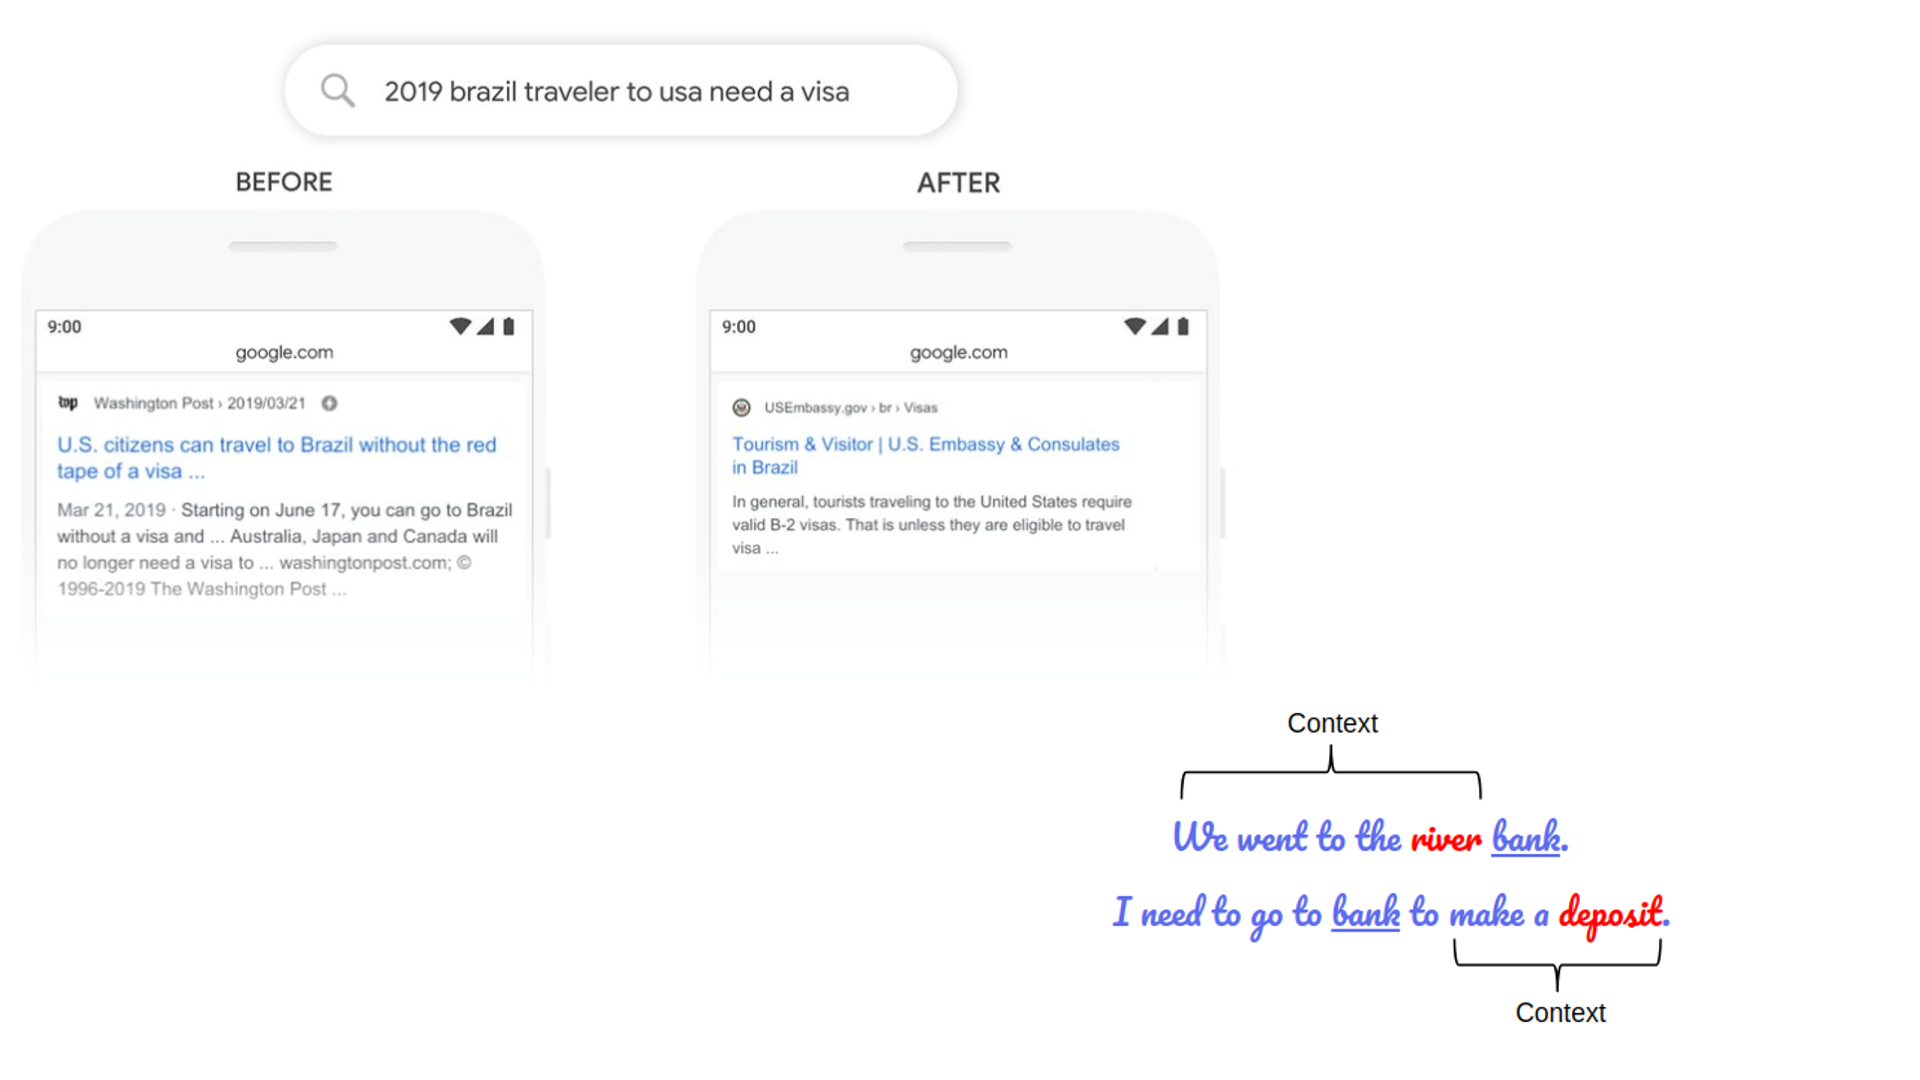

Another popular example is how BERT can understand the "no" qualifier in comparison to other models. For instance, with the query "Parking on a hill with no curb", it is not useful to show results for parking on a hill with a curb even though it is semantically close. BERT can make this subtle distinction.

Unlike some of the earlier models we have used, with BERT, you might not need to remove some of the stop words that you would otherwise remove when you used bag of words of word to vec. We will see this in the exercise below as well.

BERT https://pypi.org/project/bert-embedding/

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
!pip install -U bert-serving-server[http]

     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 358kB 15.9MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=7d2431d1d21584d7adfbe6e868cc8ba6f33e26cb0d2033d5195981c60f86d198
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
!pip install bert-serving-client

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-03-23 07:23:11--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.250.73.240, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   237MB/s    in 1.6s    

2021-03-23 07:23:13 (237 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
!nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &

In [ ]:
from bert_serving.client import BertClient 

In [ ]:
bc = BertClient()

In [ ]:
print (bc.encode(['ML', 'AI']))

[[-1.019695   -0.46916148 -0.19196992 ... -0.02251014  0.09228548
   0.17264263]
 [-0.75553846 -0.44404423 -0.34331548 ... -0.43163225 -0.06087084
   0.18810356]]


In [ ]:
question = clean_sentence(question_orig, stopwords = False)
cleaned_sentences = get_cleaned_sentences(df, stopwords = False)

sent_bertphrase_embeddings = []
for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]))
    
question_embedding = bc.encode([question])

retrieveAndPrintFAQAnswer(question_embedding, sent_bertphrase_embeddings, df, cleaned_sentences);

0 0.79674244 how can i prevent covid19
1 0.7102967 does spraying people with disinfectant lower the spread of covid19
2 0.7394058 is hand sanitizer effective against covid19
3 0.7343925 where can i buy hand sanitizer can i make my own hand sanitizer
4 0.7025206 are there any vaccines or other medical products available to prevent covid19
5 0.67584735 is it safe for me to donate blood during the coronavirus pandemic
6 0.7360525 are antibiotics effective in preventing or treating covid19
7 0.69596493 will there be drug shortages due to covid19
8 0.82617563 is there a test for covid19
9 0.6998767 is it safe to adopt pets from a shelter or rescue


Question:  how to check whether you are covid positive


Retrieved:  Is there a test for COVID-19? 

Yes, the FDA has issued Emergency Use Authorizations (EUAs) for different types of COVID-19 tests. Some tests are used to diagnose the virus that causes COVID-19 infection whereas other tests are used to detect a recent or prior COVID-19 infectio

In [ ]:
# With BOW, word2Vec and BERT with stopwords removed

question_new = input("Enter question: ")

question = clean_sentence(question_new, stopwords = True);
cleaned_sentences = get_cleaned_sentences(df, stopwords = True)

sent_embeddings = []
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent, w2v_model))

question_embedding = getPhraseEmbedding(question, w2v_model)

print("\n With Word2Vec\n\n")
retrieveAndPrintFAQAnswer(question_embedding, sent_embeddings, df, cleaned_sentences)

question = clean_sentence(question_new, stopwords = False);
cleaned_sentences = get_cleaned_sentences(df, stopwords = False)

sent_bertphrase_embeddings = []
for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]))
    
question_embedding = bc.encode([question])

print("\n\n With BERT\n\n")
retrieveAndPrintFAQAnswer(question_embedding, sent_bertphrase_embeddings, df, cleaned_sentences);

Enter question: does hand sanitizer prevent covid?

 With Word2Vec


0 0.5700469340590166 prevent covid19
1 0.4818135647347389 spraying people disinfectant lower spread covid19
2 0.8506343657853543 hand sanitizer effective covid19
3 0.8802772644346635 buy hand sanitizer hand sanitizer
4 0.4254997306631202 vaccines medical products available prevent covid19
5 0.30972425519347024 safe donate blood coronavirus pandemic
6 0.4483302490098462 antibiotics effective preventing treating covid19
7 0.2258787043808552 drug shortages covid19
8 0.19650120016012637 test covid19
9 0.23486302067799797 safe adopt pets shelter rescue


Question:  hand sanitizer prevent covid


Retrieved:  Where can I buy hand sanitizer? Can I make my own hand sanitizer? 

Many retail stores and pharmacies sell hand sanitizers. However, we understand that many stores may not have hand sanitizers available to buy. To help increase the availability of hand sanitizers, the FDA has issued guidance for the temporary preparatio

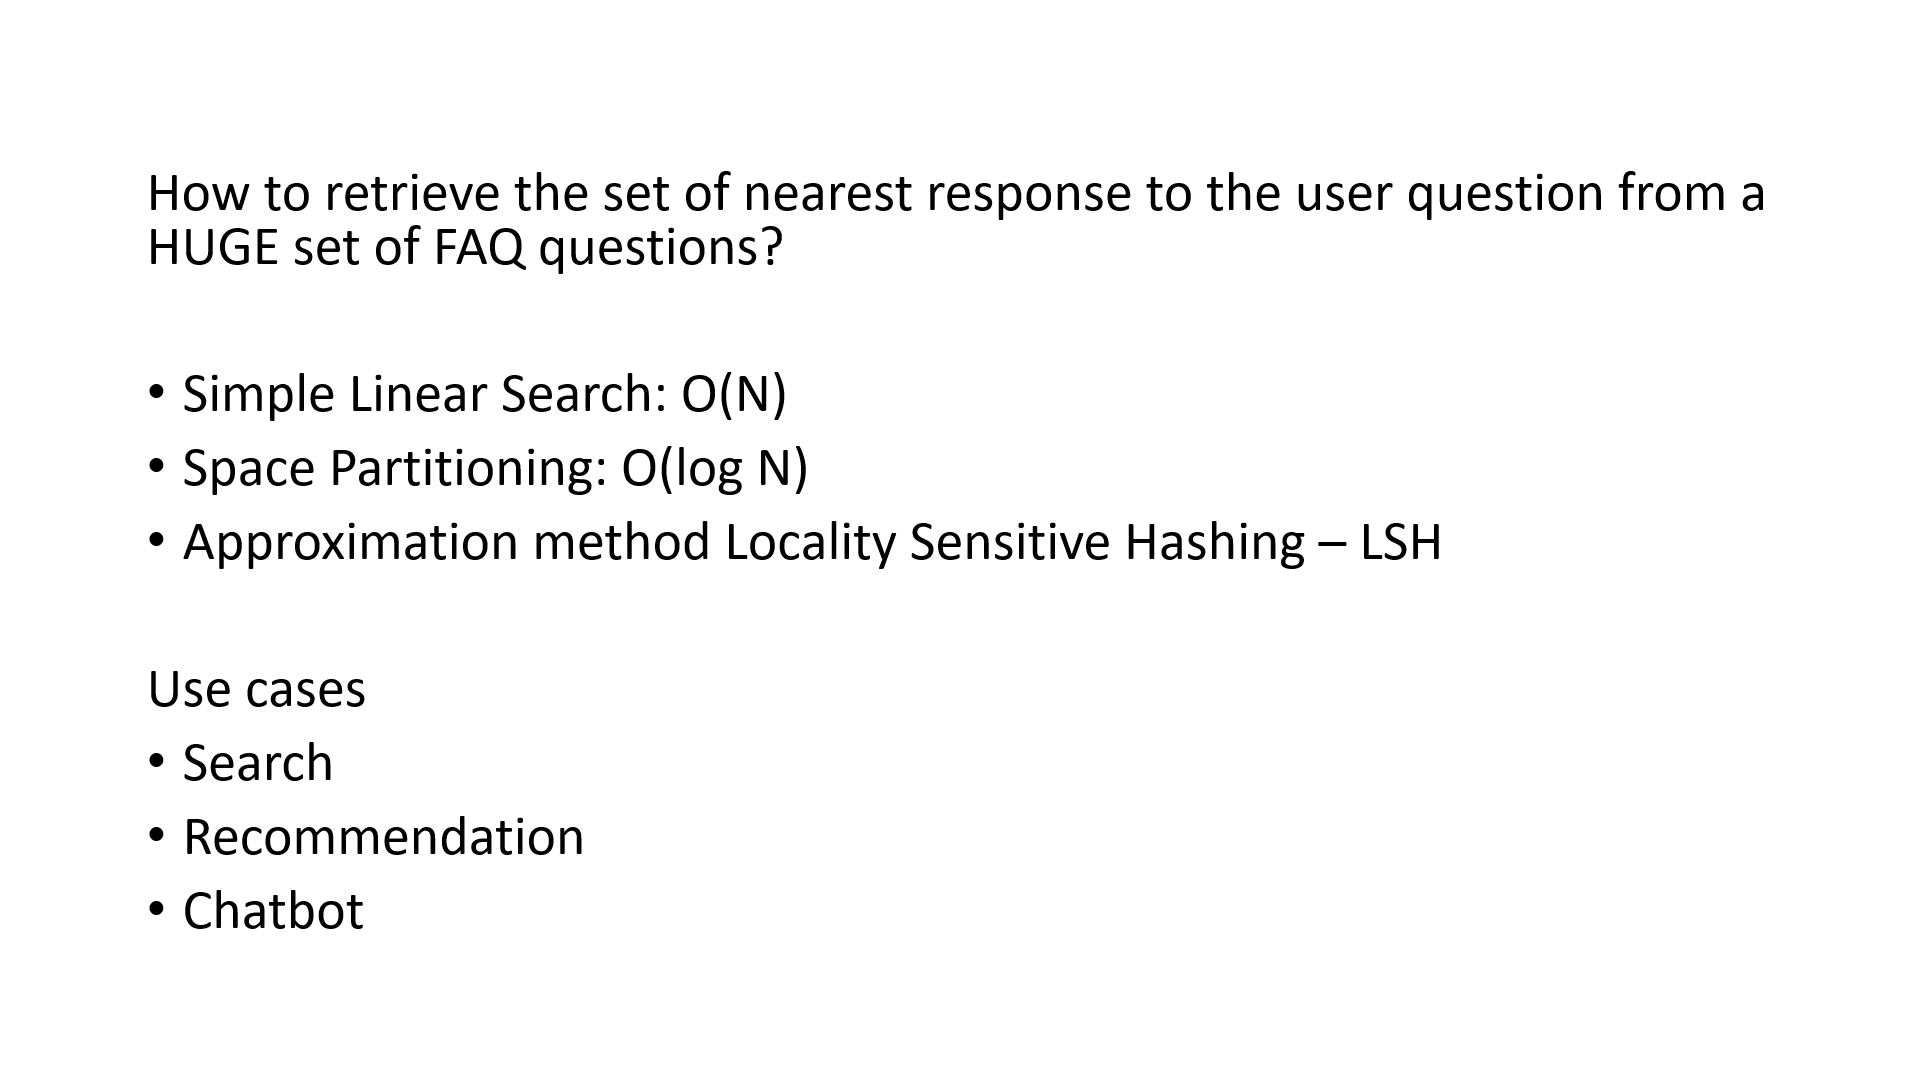

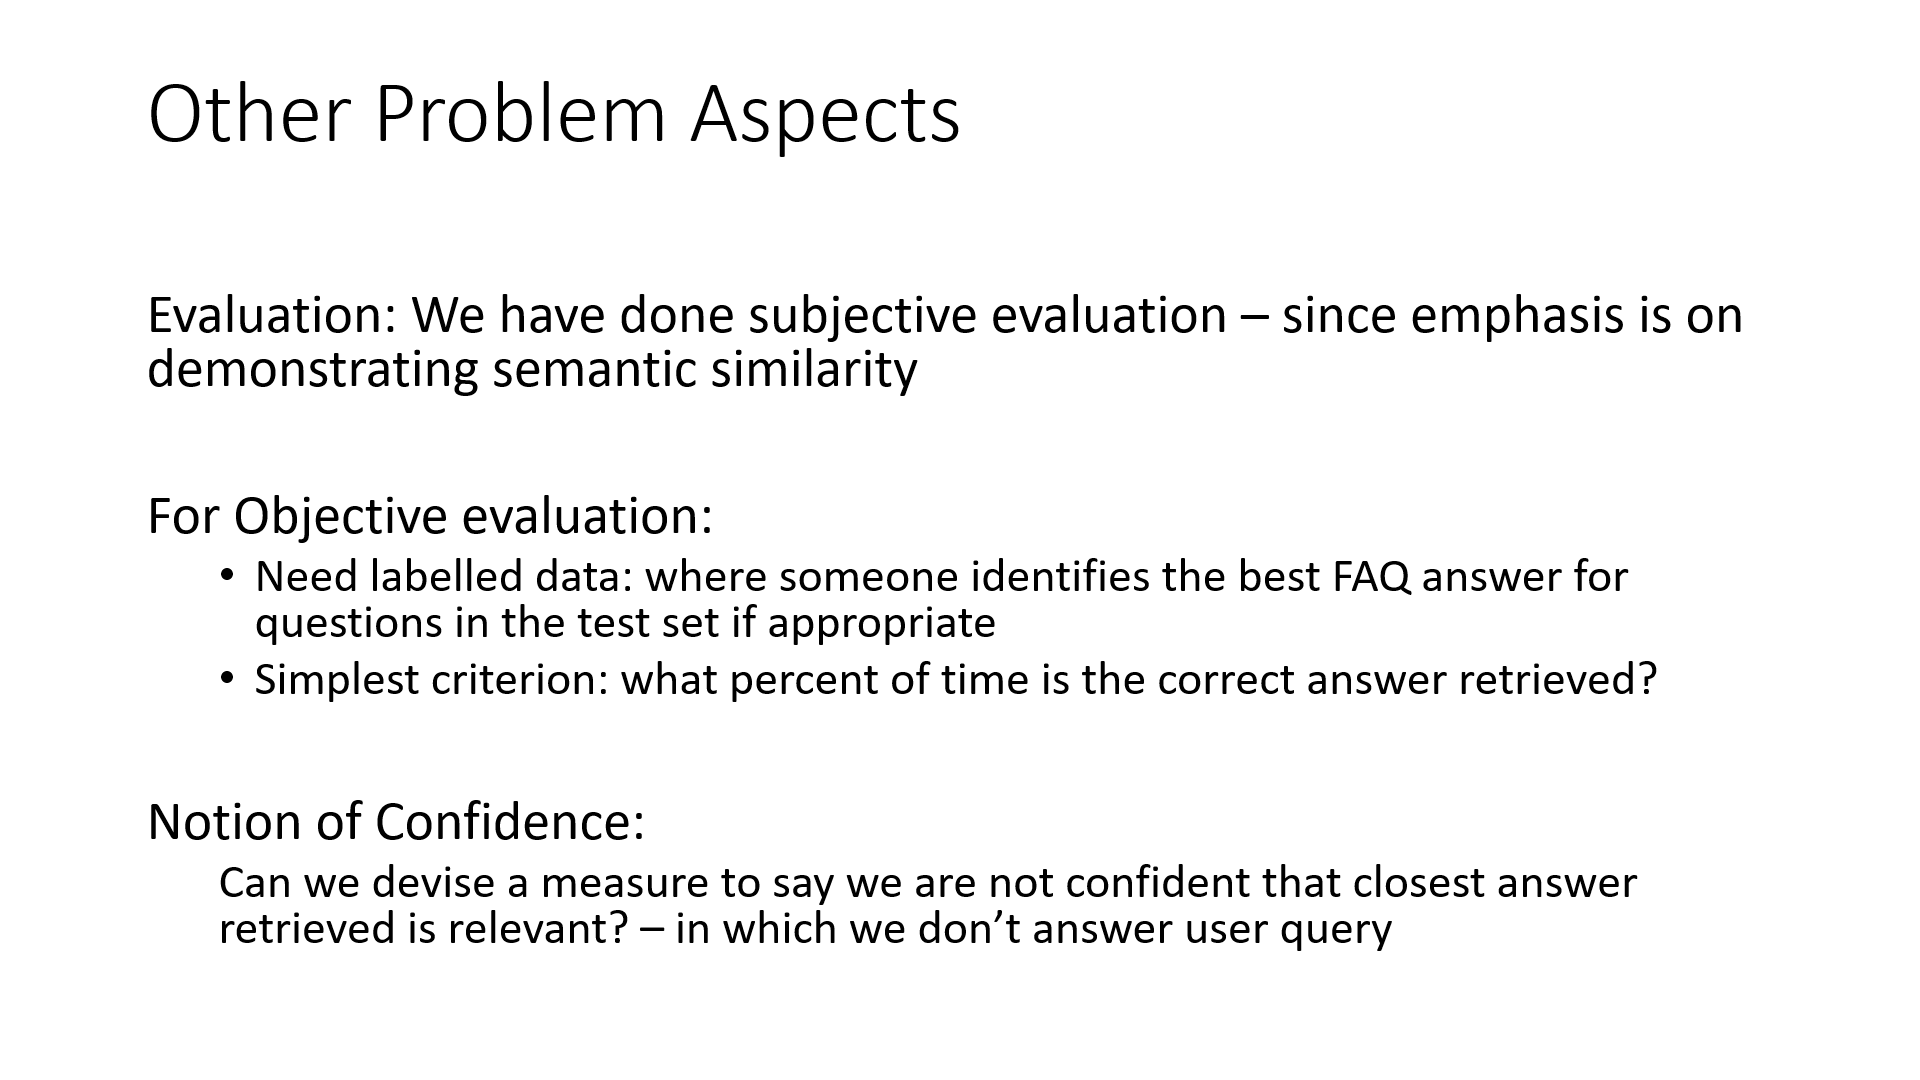

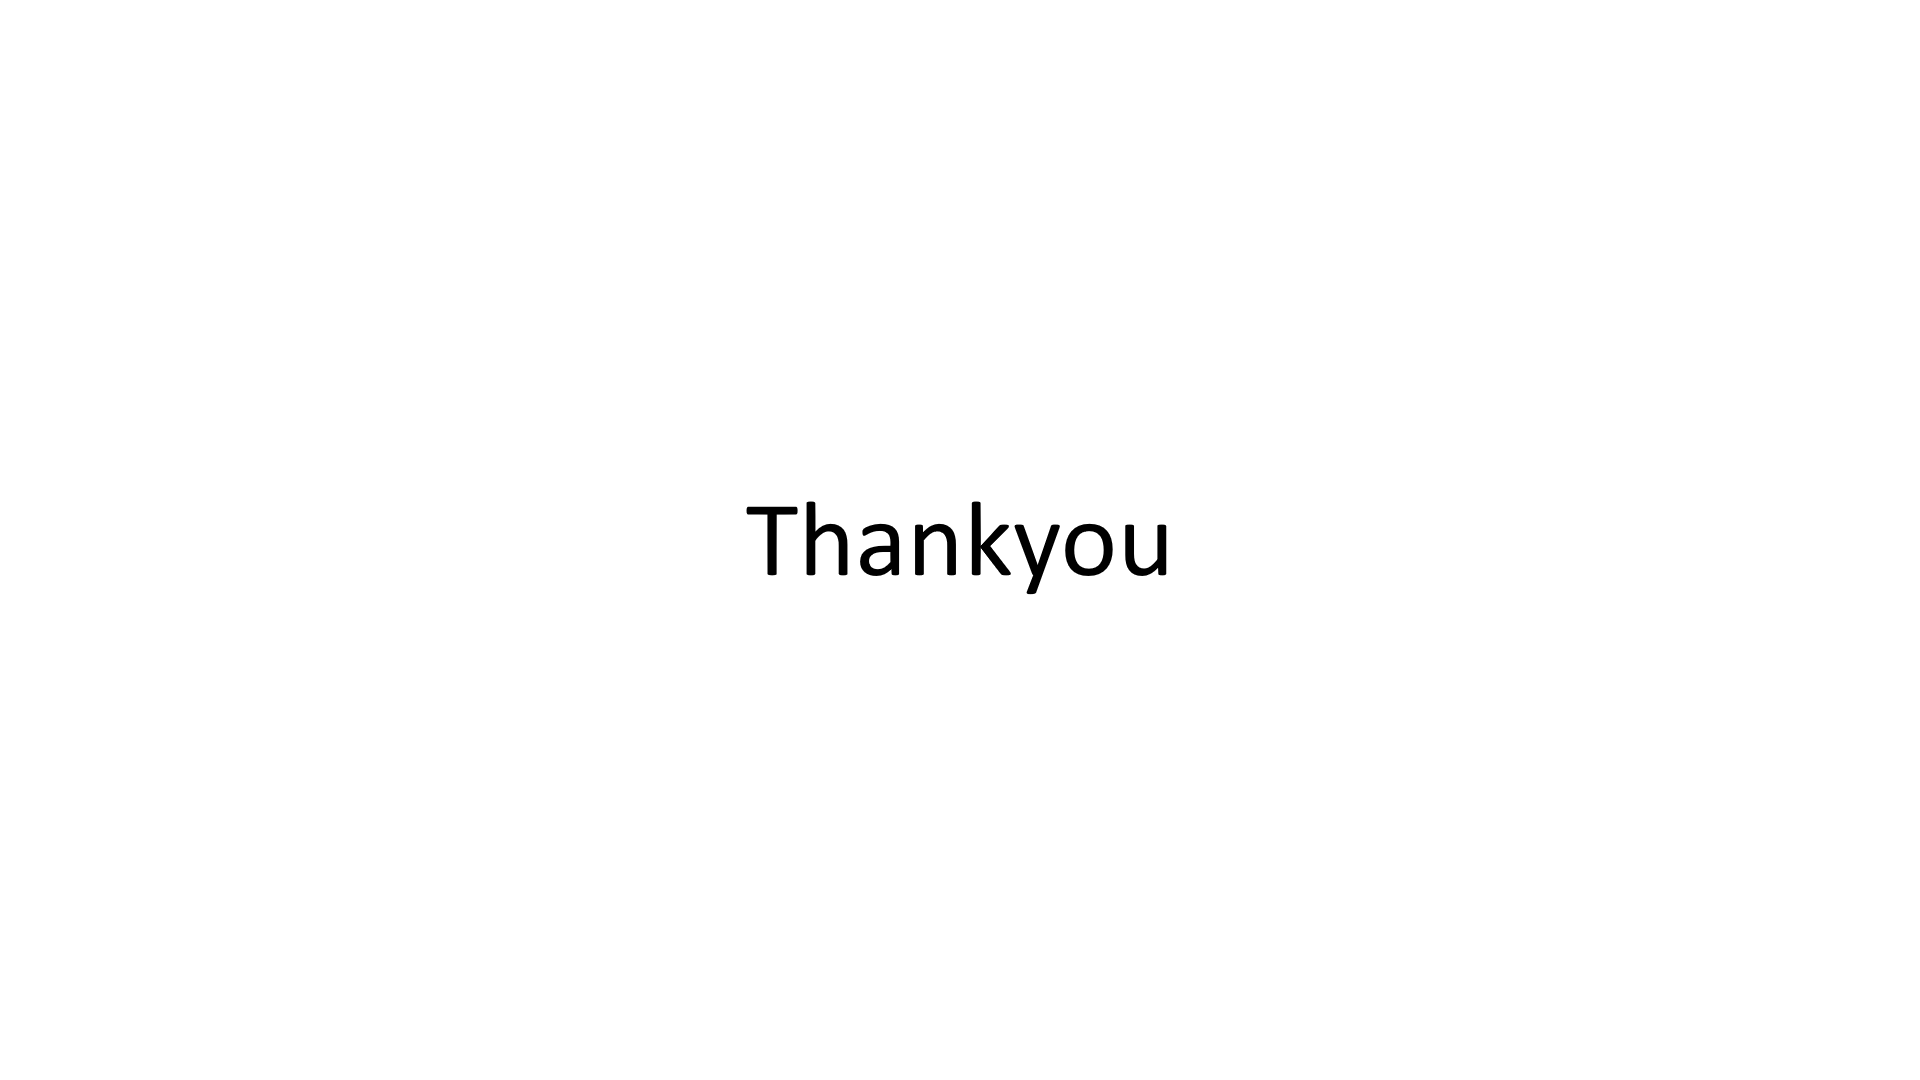